<a href="https://colab.research.google.com/github/lovepreetmultani/Anti-Money-Laundering/blob/main/No_hyperp_xgboost_Fraud_Detection_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Data load

In [1]:
!pip install torch torchvision
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=856f6910521b627888e24773e6a3b10e79afcd58b2b3f2f45679a140ed050936
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
!pip install xgboost
import xgboost as xgb


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [4]:
import torch

# Check if CUDA (GPU support for PyTorch) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using CPU


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
fraud=pd.read_csv("drive/My Drive/Dissertation/Dataset1-Big.csv")

In [7]:
fraud.head()

,tx_fraud,tx_amount,s_pagerank,s_label,s_min_send_tx,s_min_receieve_tx,s_max_send_tx,s_max_recieve_tx,s_avg_send_tx,s_avg_recieve_tx,...,r_label,r_min_send_tx,r_min_receieve_tx,r_max_send_tx,r_max_recieve_tx,r_avg_send_tx,r_avg_recieve_tx,r_cnt_recieve_tx,r_cnt_send_tx,r_timestamp
0,False,447.72,0.58295,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,...,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,200,178,199
1,False,447.72,6.36310,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,...,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,945,74,199
2,False,17.37,0.37284,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,...,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,105,220,199
3,False,17.37,0.32571,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,...,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,58,9,199
4,False,473.85,0.28323,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,...,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,27,177,199


In [8]:
fraud.columns

Index(['tx_fraud', 'tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
       's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
       's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
       's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
       'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
       'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
       'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp'],
      dtype='object')

([<matplotlib.patches.Wedge at 0x7e53f788a5f0>,
 [Text(-1.099987966091106, 0.00514533329845408, 'Not Fraud'),
  Text(1.0999879664072463, -0.005145265712377678, 'Fraud')],
 [Text(-0.5999934360496941, 0.002806545435520407, '99.85%'),
  Text(0.5999934362221343, -0.002806508570387824, '0.15%')])

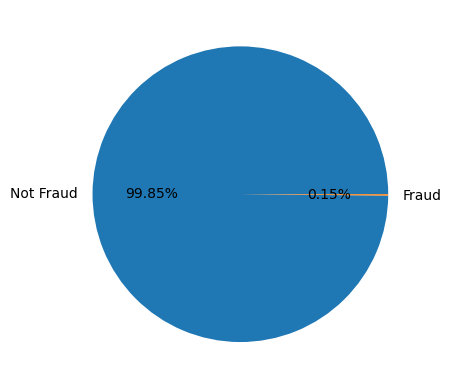

In [9]:
plt.pie(fraud['tx_fraud'].value_counts(),  labels=['Not Fraud', 'Fraud'],autopct='%.2f%%')

## Data balacing

In [10]:
from imblearn.over_sampling import SMOTE

# ... Your existing imports and code for reading data ...

# Features and labels before SMOTE
features = fraud[['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                 's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                 's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                 's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                 'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                 'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                 'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']]
labels = fraud['tx_fraud']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Replace your original 'fraud' DataFrame with the resampled data
fraud_resampled = features_resampled.copy()
fraud_resampled['tx_fraud'] = labels_resampled

In [11]:
fraud_resampled['tx_fraud'].value_counts()

False    234716
True     234716
Name: tx_fraud, dtype: int64

([<matplotlib.patches.Wedge at 0x7e53f44d4160>,
 [Text(6.735557395310444e-17, 1.1, 'Not Fraud'),
  Text(-2.0206672185931328e-16, -1.1, 'Fraud')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%')])

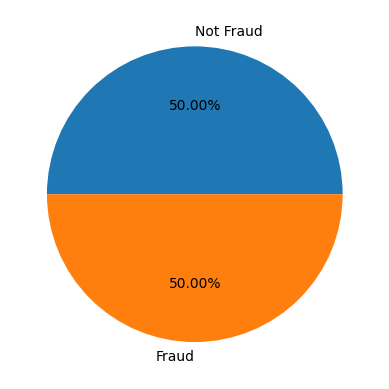

In [12]:
plt.pie(fraud_resampled['tx_fraud'].value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%.2f%%')

## Data preprocessing

In [13]:
import torch
from torch_geometric.data import Data


# Step 1: Map unique accounts to unique integer IDs
unique_accounts = pd.concat([fraud_resampled['s_label'], fraud_resampled['r_label']]).drop_duplicates()
account_to_id = {account: i for i, account in enumerate(unique_accounts)}

# Step 2: Create the edge_index tensor
source_node_indices = fraud_resampled['s_label'].map(account_to_id).values
target_node_indices = fraud_resampled['r_label'].map(account_to_id).values

edge_index = torch.tensor(
    [
        source_node_indices,  # Source nodes
        target_node_indices   # Target nodes
    ],
    dtype=torch.long
)

<ipython-input-13-170449250967>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(


In [17]:
numerical_features = fraud.select_dtypes(include=['int', 'float'])

In [18]:
from sklearn.preprocessing import StandardScaler

# Extract the features from the resampled data
features_to_scale = ['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                     's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                     's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                     's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                     'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                     'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                     'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features
fraud_data_scaled = fraud_resampled.copy()
fraud_data_scaled[features_to_scale] = scaler.fit_transform(fraud_resampled[features_to_scale])


# Use the scaled features in the resampled dataset
fraud_resampled_scaled = fraud_data_scaled.copy()

# Node features for the sender and receiver
sender_features_scaled = torch.tensor(fraud_resampled_scaled[['s_pagerank', 's_label', 's_min_send_tx',
                                  's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                                  's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                                  's_cnt_send_tx', 's_timestamp']].values, dtype=torch.float)

receiver_features_scaled = torch.tensor(fraud_resampled_scaled[['r_pagerank', 'r_label', 'r_min_send_tx',
                                    'r_min_receieve_tx', 'r_max_send_tx', 'r_max_recieve_tx',
                                    'r_avg_send_tx', 'r_avg_recieve_tx', 'r_cnt_recieve_tx',
                                    'r_cnt_send_tx', 'r_timestamp']].values, dtype=torch.float)

# Combining the sender and receiver features
x_scaled = torch.cat([sender_features_scaled, receiver_features_scaled], dim=1)

# Edge features
edge_attr_scaled = torch.tensor(fraud_resampled_scaled[['tx_amount']].values, dtype=torch.float)

# Create a PyTorch Geometric data object with scaled features
data_scaled = Data(x=x_scaled, edge_index=edge_index, edge_attr=edge_attr_scaled)


## XGBoost

Test train split

In [19]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

In [20]:
X_train = fraud_resampled_scaled.loc[train_fraud.index, features_to_scale]
y_train = fraud_resampled_scaled.loc[train_fraud.index, 'tx_fraud']

X_val = fraud_resampled_scaled.loc[val_fraud.index, features_to_scale]
y_val = fraud_resampled_scaled.loc[val_fraud.index, 'tx_fraud']

X_test = fraud_resampled_scaled.loc[test_fraud.index, features_to_scale]
y_test = fraud_resampled_scaled.loc[test_fraud.index, 'tx_fraud']




Train

In [21]:
from xgboost import XGBRFClassifier
# Training the XGBoost model
''' xgb_model = XGBRFClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2, scale_pos_weight=400,
    min_child_weight=80, gamma=10, max_delta_step=2
) '''

xgb_model = XGBRFClassifier(
    n_estimators=10, max_depth=3, learning_rate=0.01, objective='binary:logistic',
    booster='gbtree', gamma=0, min_child_weight=1

)


xgb_model.fit(X_train, y_train, eval_metric='error', eval_set=[(X_train, y_train), (X_val, y_val)])

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best XGBoost model
xgb_test_predictions = xgb_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
xgb_time= end_time - start_time

# Evaluate the XGBoost model using Precision on the test set
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print(f"XGBoost Test Precision: {xgb_test_precision}")

# Making predictions on the validation set using XGBoost
xgb_val_predictions = xgb_model.predict(X_val)

# Evaluate the XGBoost model using Precision on validation set
xgb_val_precision = precision_score(y_val, xgb_val_predictions)
print(f"XGBoost Validation Precision: {xgb_val_precision}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.03383	validation_1-error:0.03399
Time taken for test set prediction: 0.0327 seconds
XGBoost Test Precision: 0.9693516193419612
XGBoost Validation Precision: 0.9696436238729068


Confusion Matrix:
[[45516  1428]
 [ 1778 45165]]


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.97     46944
        True       0.97      0.96      0.97     46943

    accuracy                           0.97     93887
   macro avg       0.97      0.97      0.97     93887
weighted avg       0.97      0.97      0.97     93887



Accuracy: 0.9658525674481026


Precision: 0.9693516193419612
Recall: 0.9621242783801631
f1 score: 0.965724426958604
0.9658525277381389


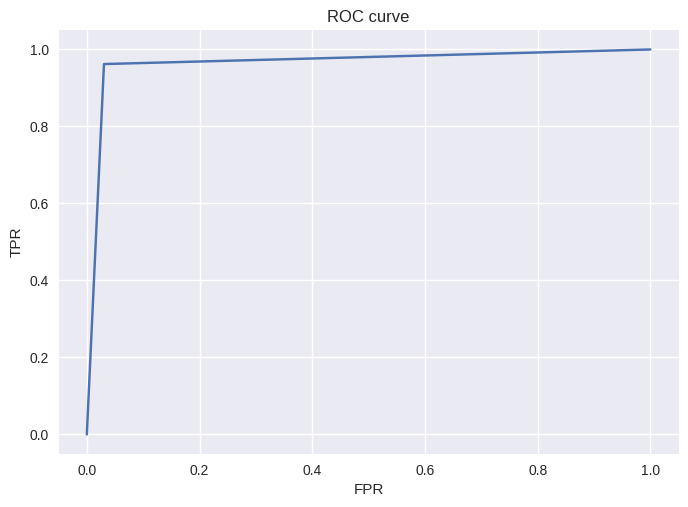

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
x_result = confusion_matrix(y_test, xgb_test_predictions)
print("Confusion Matrix:")
print(x_result)
print('\n')
result1 = classification_report(y_test, xgb_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
x_result2 = accuracy_score(y_test,xgb_test_predictions)
print("Accuracy:",x_result2)
print('\n')
# calculate precision and recall scores
x_precision = precision_score(y_test, xgb_test_predictions)
x_recall = recall_score(y_test, xgb_test_predictions)
x_f1score = f1_score(y_test, xgb_test_predictions)

# print the results
print("Precision:", x_precision)
print("Recall:", x_recall)
print("f1 score:", x_f1score)

print(roc_auc_score(y_test, xgb_test_predictions))

fpr, tpr, _ = roc_curve(y_test, xgb_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

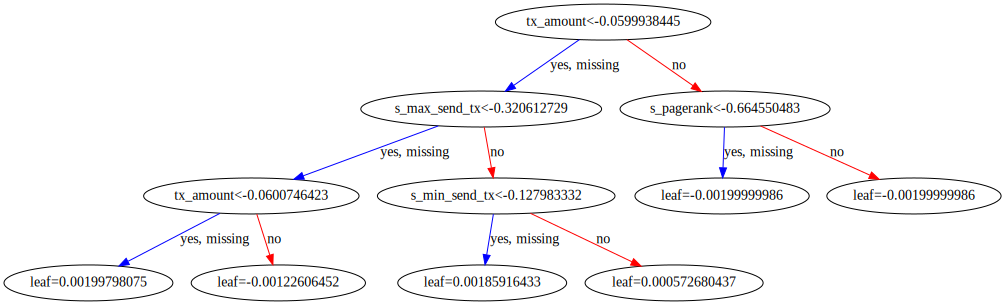

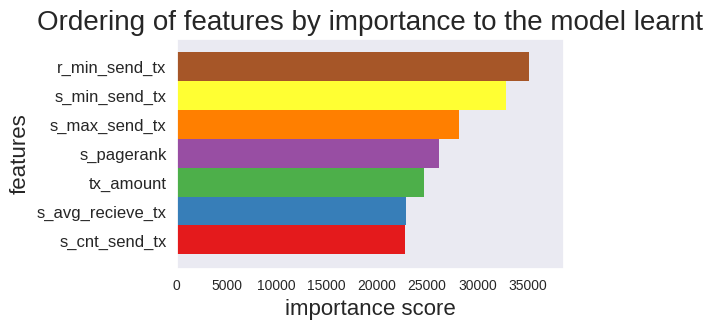

In [23]:
from xgboost import plot_importance, to_graphviz
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
to_graphviz(xgb_model)

## KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Training the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fitting the model on the training set
knn_model.fit(X_train, y_train)

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best KNN model
knn_test_predictions = knn_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
knn_time= end_time - start_time

# Evaluate the KNN model using Precision on the test set
knn_test_precision = precision_score(y_test, knn_test_predictions)
print(f"KNN Test precision: {knn_test_precision}")

# Making predictions on the validation set using KNN
knn_val_predictions = knn_model.predict(X_val)

# Evaluate the KNN model using Precision on the validation set
knn_val_precision = precision_score(y_val, knn_val_predictions)
print(f"KNN Validation precision: {knn_val_precision}")


Time taken for test set prediction: 167.4115 seconds
KNN Test precision: 0.978614325472389
KNN Validation precision: 0.9794576484137787


Confusion Matrix:
[[45922  1022]
 [  176 46767]]


Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.98      0.99     46944
        True       0.98      1.00      0.99     46943

    accuracy                           0.99     93887
   macro avg       0.99      0.99      0.99     93887
weighted avg       0.99      0.99      0.99     93887



Accuracy: 0.9872399799759285


Precision: 0.978614325472389
Recall: 0.9962507722131095
f1 score: 0.987353798083013
0.9872400759497721


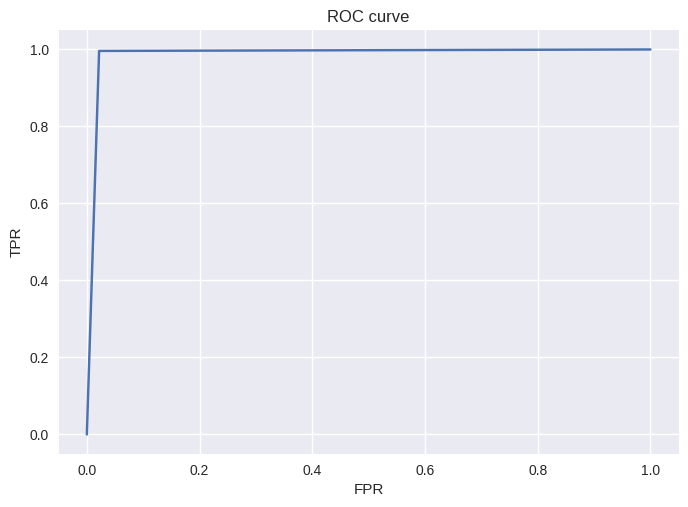

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
k_result = confusion_matrix(y_test, knn_test_predictions)
print("Confusion Matrix:")
print(k_result)
print('\n')
result1 = classification_report(y_test, knn_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
k_result2 = accuracy_score(y_test,knn_test_predictions)
print("Accuracy:",k_result2)
print('\n')
# calculate precision and recall scores
k_precision = precision_score(y_test, knn_test_predictions)
k_recall = recall_score(y_test, knn_test_predictions)
k_f1score = f1_score(y_test, knn_test_predictions)

# print the results
print("Precision:", k_precision)
print("Recall:", k_recall)
print("f1 score:", k_f1score)

print(roc_auc_score(y_test, knn_test_predictions))

fpr, tpr, _ = roc_curve(y_test, knn_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

##Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, min_samples_split=2,
    min_samples_leaf=1, random_state=42
)

# Training the Decision Tree model
dt_model.fit(X_train, y_train)

# Making predictions on the validation set using the Decision Tree model
dt_val_predictions = dt_model.predict(X_val)

# Evaluate the Decision Tree model using Precision on the validation set
dt_val_precision = precision_score(y_val, dt_val_predictions)
print(f"Decision Tree Validation precision: {dt_val_precision}")


# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best Decision Tree model
dt_test_predictions = dt_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
dt_time= end_time - start_time

# Evaluate the Decision Tree model using Precision on the test set
dt_test_precision = precision_score(y_test, dt_test_predictions)
print(f"Decision Tree Test precision: {dt_test_precision}")


Decision Tree Validation precision: 0.9554851927733283
Time taken for test set prediction: 0.0212 seconds
Decision Tree Test precision: 0.955251349283484


Confusion Matrix:
[[44780  2164]
 [  748 46195]]


Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.95      0.97     46944
        True       0.96      0.98      0.97     46943

    accuracy                           0.97     93887
   macro avg       0.97      0.97      0.97     93887
weighted avg       0.97      0.97      0.97     93887



Accuracy: 0.9689839913939097


Precision: 0.955251349283484
Recall: 0.9840657819057155
f1 score: 0.9694445027386623
ROC AUC Score 0.9689841520298856


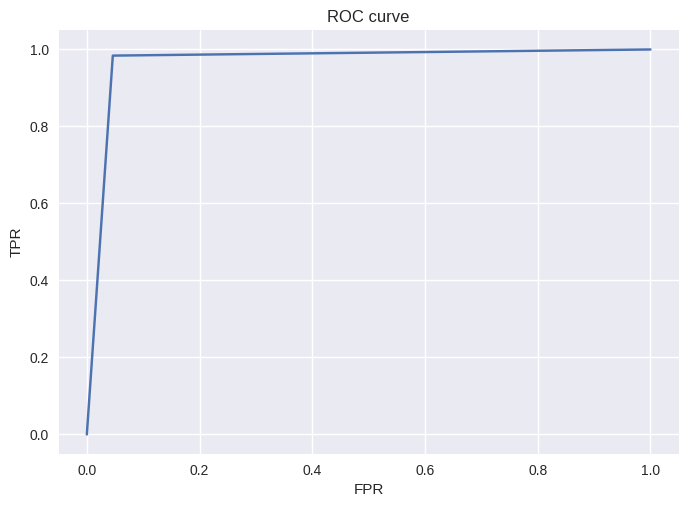

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
dt_result = confusion_matrix(y_test, dt_test_predictions)
print("Confusion Matrix:")
print(dt_result)
print('\n')
result1 = classification_report(y_test, dt_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
d_result2 = accuracy_score(y_test,dt_test_predictions)
print("Accuracy:",d_result2)
print('\n')
# calculate precision and recall scores
d_precision = precision_score(y_test, dt_test_predictions)
d_recall = recall_score(y_test, dt_test_predictions)
d_f1score = f1_score(y_test, dt_test_predictions)


# print the results
print("Precision:", d_precision)
print("Recall:", d_recall)
print("f1 score:", d_f1score)

print("ROC AUC Score",roc_auc_score(y_test, dt_test_predictions))

fpr, tpr, _ = roc_curve(y_test, dt_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Random Forest


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model on the training set
rf_model.fit(X_train, y_train)

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best Random Forest model
rf_test_predictions = rf_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
rf_time= end_time - start_time

# Evaluate the Random Forest model using Precision on the test set
rf_test_precision = precision_score(y_test, rf_test_predictions)
print(f"Random Forest Test precision: {rf_test_precision}")

# Making predictions on the validation set using Random Forest
rf_val_predictions = rf_model.predict(X_val)

# Evaluate the Random Forest model using Precision on the validation set
rf_val_precision = precision_score(y_val, rf_val_predictions)
print(f"Random Forest Validation precision: {rf_val_precision}")



Time taken for test set prediction: 1.1347 seconds
Random Forest Test precision: 0.9992760258075506
Random Forest Validation precision: 0.9993186415415735


Confusion Matrix:
[[46910    34]
 [   14 46929]]


Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     46944
        True       1.00      1.00      1.00     46943

    accuracy                           1.00     93887
   macro avg       1.00      1.00      1.00     93887
weighted avg       1.00      1.00      1.00     93887



Accuracy: 0.9994887471108886


Precision: 0.9992760258075506
Recall: 0.9997017659714974
f1 score: 0.9994888505526803
0.99948874937975


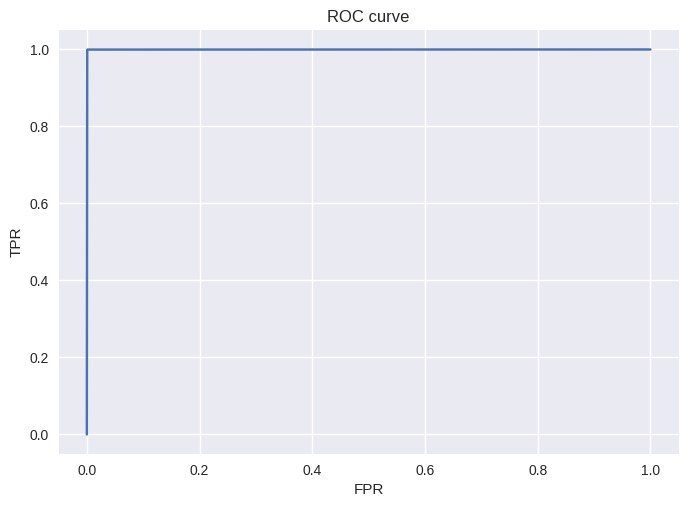

In [29]:
rf_result = confusion_matrix(y_test, rf_test_predictions)
print("Confusion Matrix:")
print(rf_result)
print('\n')
result1 = classification_report(y_test, rf_test_predictions)
print("Classification Report:",)
print(result1)
print('\n')
rf_result2 = accuracy_score(y_test, rf_test_predictions)
print("Accuracy:", rf_result2)
print('\n')

# Calculate precision, recall, and F1-score
rf_precision = precision_score(y_test, rf_test_predictions)
rf_recall = recall_score(y_test, rf_test_predictions)
rf_f1score = f1_score(y_test, rf_test_predictions)

# Print the results
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("f1 score:", rf_f1score)
print(roc_auc_score(y_test, rf_test_predictions))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_test_predictions)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## GNN


Model building

In [30]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [31]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 32)  # Increased from 16 to 32
        self.conv2 = GCNConv(32, 16)  # New layer
        self.conv3 = GCNConv(16, 2)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # New layer
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


Test train split

In [32]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

# Initialize masks
train_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
val_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
test_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)

# Update masks based on the indices of the train, validation and test sets
train_mask[train_fraud.index] = True
val_mask[val_fraud.index] = True
test_mask[test_fraud.index] = True

# Update your data object
data_scaled.train_mask = train_mask
data_scaled.val_mask = val_mask
data_scaled.test_mask = test_mask
data_scaled.y = torch.tensor(fraud_resampled_scaled['tx_fraud'].values, dtype=torch.long)

Training

In [33]:
# Number of node features
num_node_features = x_scaled.shape[1]

In [34]:
# Initialize the model and optimizer
GN_model = GNNModel(data_scaled.num_node_features)
optimizer = torch.optim.Adam(GN_model.parameters(), lr=0.01)

# Lists to hold loss and precision values for plotting or analysis
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []

# Training loop with validation
for epoch in range(200):
    GN_model.train()
    optimizer.zero_grad()
    out = GN_model(data_scaled)

    # Training loss
    train_loss = F.nll_loss(out[data_scaled.train_mask], data_scaled.y[data_scaled.train_mask])
    train_loss.backward()
    optimizer.step()

    # Calculate training precision
    _, train_pred = out[data_scaled.train_mask].max(dim=1)
    train_true = data_scaled.y[data_scaled.train_mask]
    train_precision = precision_score(train_true.cpu(), train_pred.cpu(), average='micro')

    # Validation
    GN_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Deactivate autograd engine to reduce memory usage and speed up computations
        val_loss = F.nll_loss(out[data_scaled.val_mask], data_scaled.y[data_scaled.val_mask])

        # Calculate validation precision
        _, val_pred = out[data_scaled.val_mask].max(dim=1)
        val_true = data_scaled.y[data_scaled.val_mask]
        val_precision = precision_score(val_true.cpu(), val_pred.cpu(), average='micro')

    # Print the metrics
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Training Precision: {train_precision}, Validation Precision: {val_precision}")

Epoch 1, Training Loss: 0.8002579212188721, Validation Loss: 0.7973843216896057, Training Precision: 0.5043936107136644, Validation Precision: 0.5051232345610634
Epoch 2, Training Loss: 0.7156568765640259, Validation Loss: 0.7149444222450256, Training Precision: 0.5289232724677713, Validation Precision: 0.5295464712523699
Epoch 3, Training Loss: 0.6836879253387451, Validation Loss: 0.6846189498901367, Training Precision: 0.5518836607386947, Validation Precision: 0.5522868159256972
Epoch 4, Training Loss: 0.6714127063751221, Validation Loss: 0.6714828014373779, Training Precision: 0.5778618826311249, Validation Precision: 0.5782970836972499
Epoch 5, Training Loss: 0.6636137962341309, Validation Loss: 0.6635323166847229, Training Precision: 0.6029844599320455, Validation Precision: 0.6032635323690433
Epoch 6, Training Loss: 0.6557256579399109, Validation Loss: 0.6560432314872742, Training Precision: 0.6175304179877086, Validation Precision: 0.6174829047994376
Epoch 7, Training Loss: 0.64

In [35]:
# Testing and Evaluation
GN_model.eval()
_, pred = out.max(dim=1)
correct = float(pred[data_scaled.test_mask].eq(data_scaled.y[data_scaled.test_mask]).sum().item())
acc = correct / data_scaled.test_mask.sum().item()
print(f"Test Accuracy: {acc}")

from sklearn.metrics import precision_score

# Testing and Evaluation
GN_model.eval()
# Start the timer before making predictions
start_time = time.time()
_, pred = out.max(dim=1)
# Stop the timer after making predictions
end_time = time.time()

print(f"Time taken for testing: {end_time - start_time:.4f} seconds")
g_time= end_time - start_time

# Extract ground truth and predictions for test set
true_labels = data_scaled.y[data_scaled.test_mask].cpu().numpy()
predicted_labels = pred[data_scaled.test_mask].cpu().numpy()

Test Accuracy: 0.8577864880121848
Time taken for testing: 0.0036 seconds


Confusion Matrix:
[[34859 12085]
 [ 1267 45676]]


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     46944
           1       0.79      0.97      0.87     46943

    accuracy                           0.86     93887
   macro avg       0.88      0.86      0.86     93887
weighted avg       0.88      0.86      0.86     93887



Accuracy: 0.8577864880121848


Precision: 0.7907757829677464
Recall: 0.97300982042051
f1 score: 0.8724786063569683
0.8577877152545631


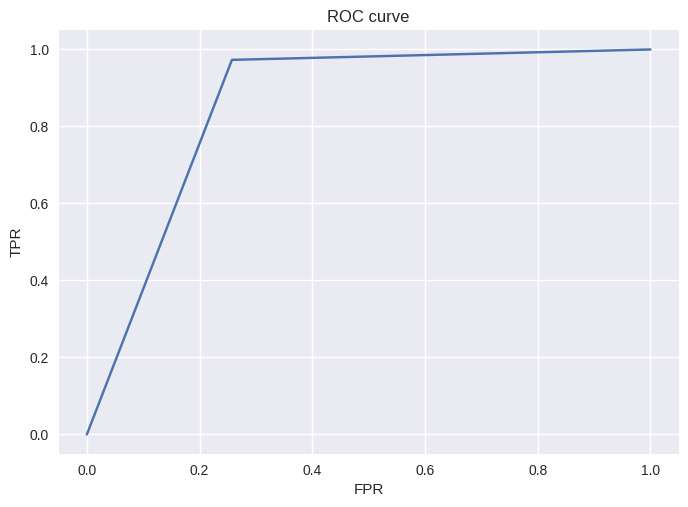

In [36]:
from sklearn.metrics import f1_score
g_result = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(g_result)
print('\n')
result1 = classification_report(true_labels, predicted_labels)
print("Classification Report:",)
print (result1)
print('\n')
g_result2 = accuracy_score(true_labels,predicted_labels)
print("Accuracy:",g_result2)
print('\n')
# calculate precision and recall scores
g_precision = precision_score(true_labels, predicted_labels)
g_recall = recall_score(true_labels, predicted_labels)
g_f1score = f1_score(true_labels, predicted_labels)

# print the results
print("Precision:", g_precision)
print("Recall:", g_recall)
print("f1 score:", g_f1score)

print(roc_auc_score(true_labels, predicted_labels))

fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

ValueError: ignored

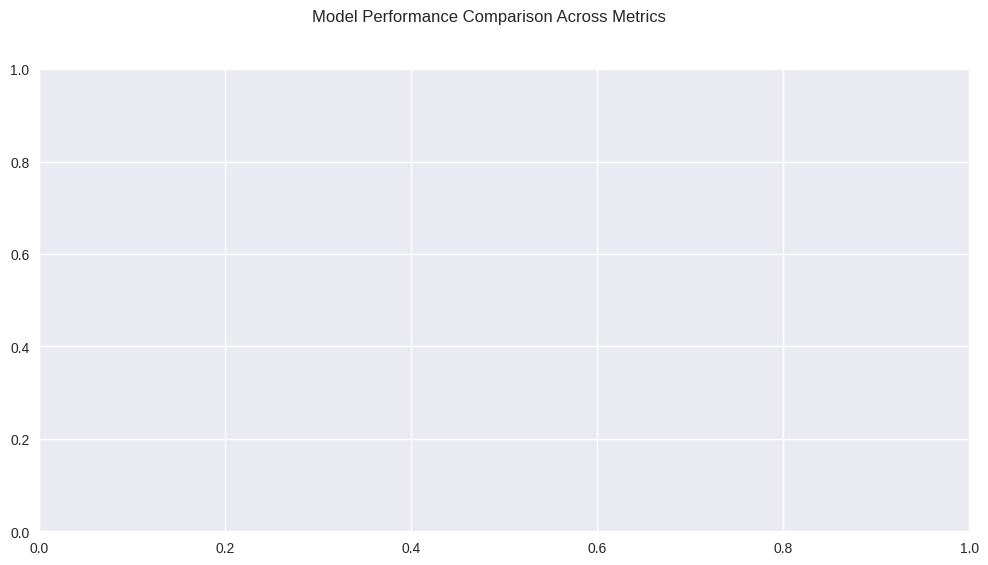

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their performance metrics
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Random Forest' 'Graph Convolution Network']
accuracy = [k_result2, x_result2, d_result2, rf_result2, g_result2]
precision = [k_precision, x_precision, d_precision, rf_precision, g_precision]
recall = [k_recall, x_recall, d_recall, rf_recall, g_recall]
f1_score = [k_f1score, x_f1score, d_f1score, rf_f1score, g_f1score]

# Create a single plot for all metrics using grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Performance Comparison Across Metrics')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.2

# Plot bars for each metric
rects1 = ax.bar(pos - bar_width*1.5, accuracy, bar_width, label='Accuracy', color='blue')
rects2 = ax.bar(pos - bar_width/2, precision, bar_width, label='Precision', color='green')
rects3 = ax.bar(pos + bar_width/2, recall, bar_width, label='Recall', color='red')
rects4 = ax.bar(pos + bar_width*1.5, f1_score, bar_width, label='F1 Score', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Metrics Value')
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_ylim([0.7, 1.0])
ax.legend()

# Label with specially formatted floats
ax.bar_label(rects1, fmt='%.3f')
ax.bar_label(rects2, fmt='%.3f')
ax.bar_label(rects3, fmt='%.3f')
ax.bar_label(rects4, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


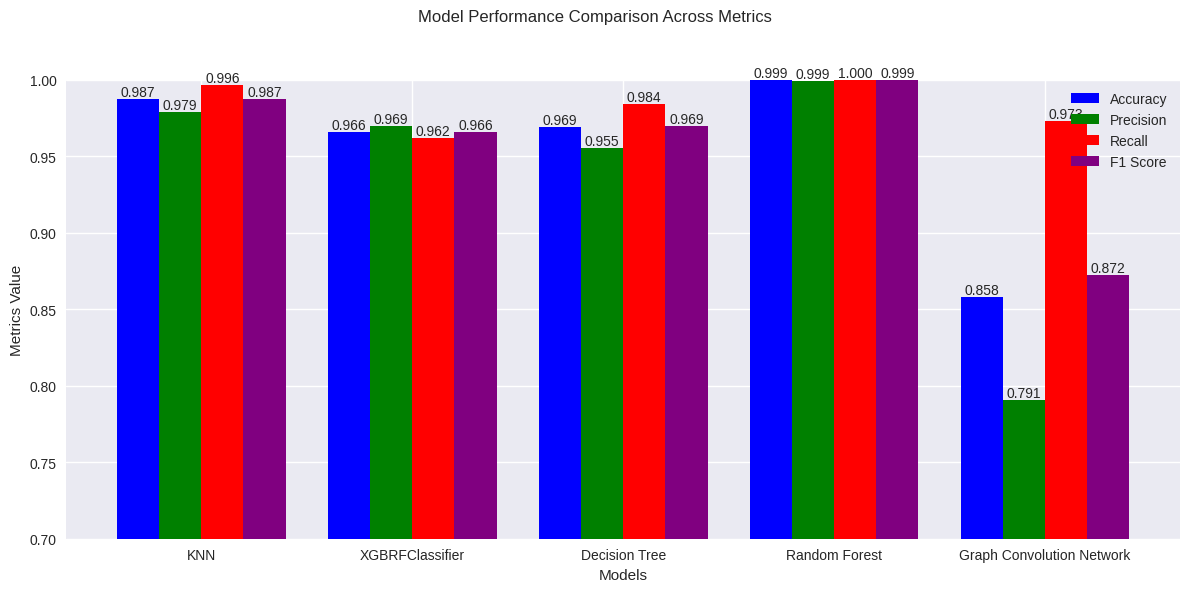

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their performance metrics
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Random Forest', 'Graph Convolution Network']
accuracy = [k_result2, x_result2, d_result2, rf_result2, g_result2]
precision = [k_precision, x_precision, d_precision, rf_precision, g_precision]
recall = [k_recall, x_recall, d_recall, rf_recall, g_recall]
f1_score = [k_f1score, x_f1score, d_f1score, rf_f1score, g_f1score]

# Create a single plot for all metrics using a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Performance Comparison Across Metrics')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.2

# Plot bars for each metric
rects1 = ax.bar(pos - bar_width*1.5, accuracy, bar_width, label='Accuracy', color='blue')
rects2 = ax.bar(pos - bar_width/2, precision, bar_width, label='Precision', color='green')
rects3 = ax.bar(pos + bar_width/2, recall, bar_width, label='Recall', color='red')
rects4 = ax.bar(pos + bar_width*1.5, f1_score, bar_width, label='F1 Score', color='purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Metrics Value')
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_ylim([0.7, 1.0])
ax.legend()

# Label with specially formatted floats
ax.bar_label(rects1, fmt='%.3f')
ax.bar_label(rects2, fmt='%.3f')
ax.bar_label(rects3, fmt='%.3f')
ax.bar_label(rects4, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [39]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=a9588730234a61fe15b5095c02ce75f69ec2e9a509287f2db456067cc43ce988
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


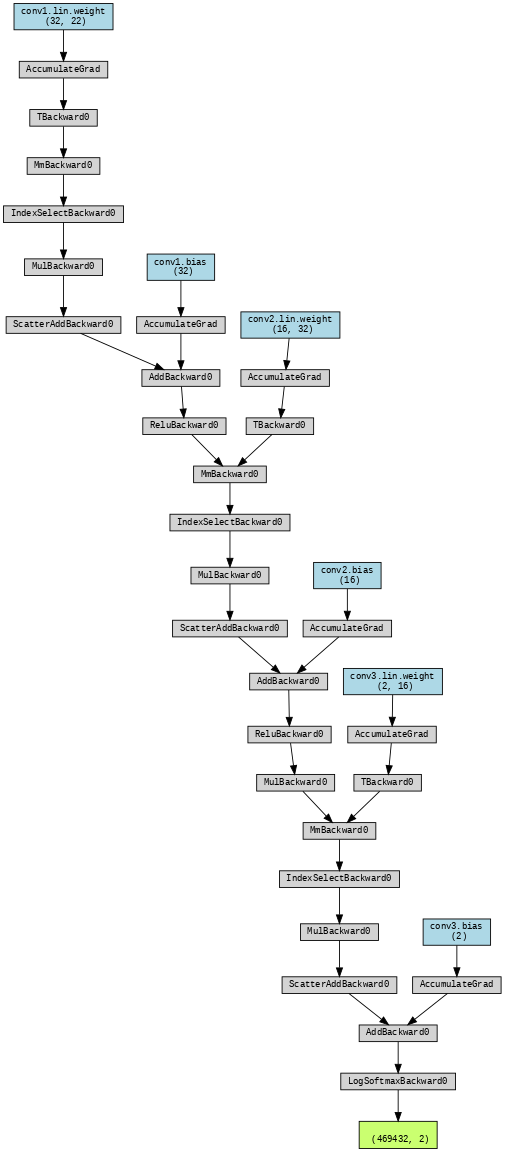

In [40]:
import torch
from torchviz import make_dot
from IPython.display import Image
import os

# Initialize the model
GN_model = GNNModel(data_scaled.num_node_features)

# Generate dummy output using a sample from your dataset
dummy_output = GN_model(data_scaled)

# Generate the visualization
dot = make_dot(dummy_output, params=dict(GN_model.named_parameters()))

# Save and display
dot.format = 'png'
dot.render(filename='architecture', directory='./', cleanup=True)
display(Image(filename='architecture.png'))


In [41]:
!pip install hiddenlayer


## Comparisions

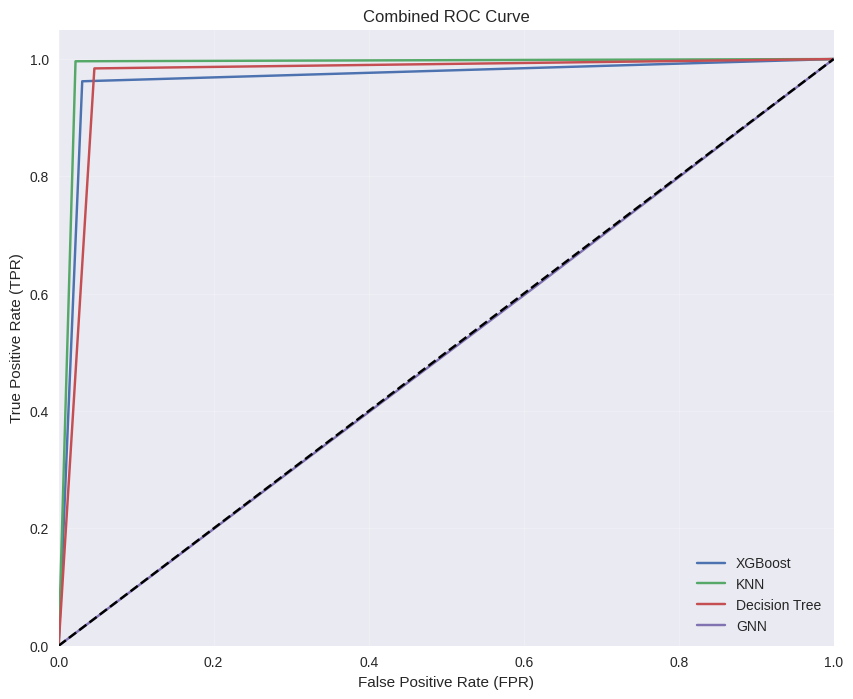

In [42]:
# Define a function to plot the combined ROC curves
def plot_combined_roc(y_test, *models):
    plt.figure(figsize=(10, 8))

    for model_predictions, model_name in models:
        fpr, tpr, _ = roc_curve(y_test, model_predictions)
        plt.plot(fpr, tpr, label=f'{model_name}')

    # Formatting
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal 45 degree line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Combined ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.2)
    plt.show()

# Call the function after predictions for each model are available
plot_combined_roc(y_test,
                  (xgb_test_predictions, "XGBoost"),
                  (knn_test_predictions, "KNN"),
                  (dt_test_predictions, "Decision Tree"),
                  (predicted_labels, "GNN"))  # assuming 'predicted_labels' is the GNN's predictions


time comparision

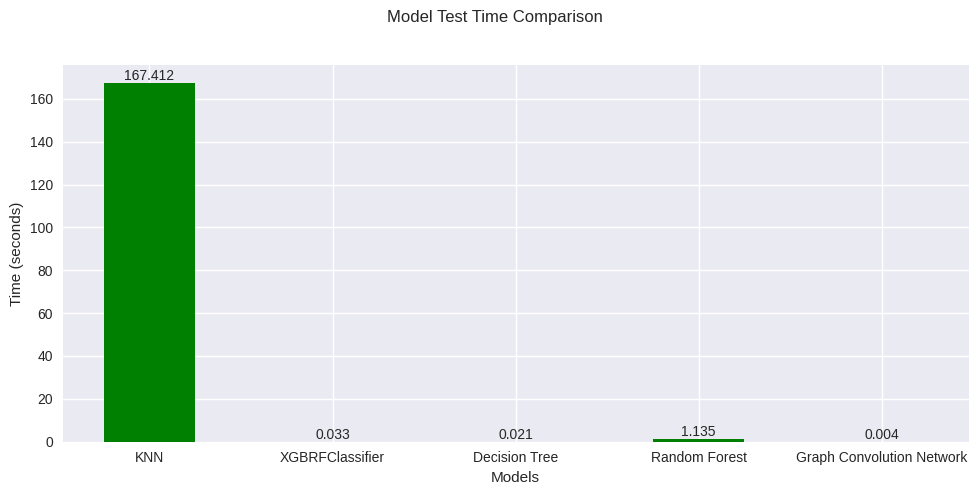

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their time taken for processing test data
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Random Forest', 'Graph Convolution Network']
times = [knn_time, xgb_time, dt_time, rf_time, g_time]

# Create a single bar plot to compare the time taken by each model
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Model Test Time Comparison')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.5

# Plot bars for the time taken
rects = ax.bar(pos, times, bar_width, color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(pos)
ax.set_xticklabels(models)

# Label with specially formatted floats
ax.bar_label(rects, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


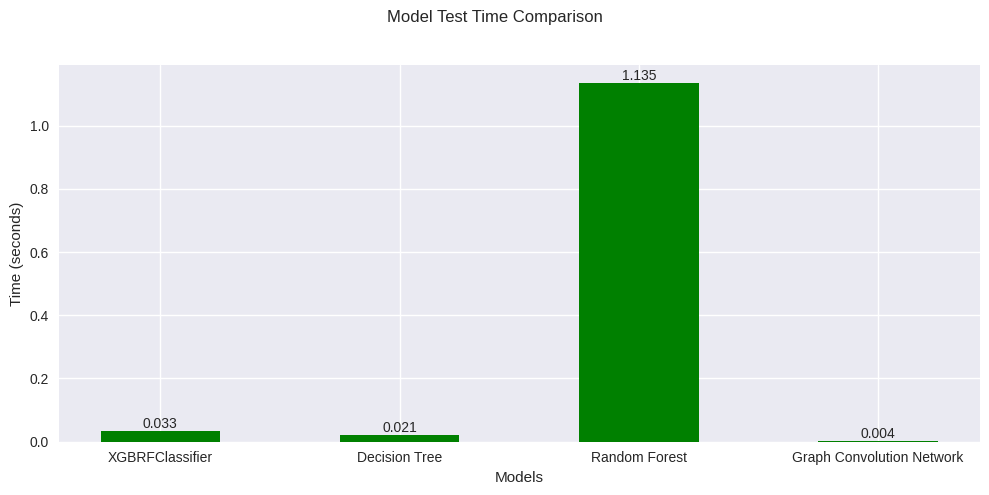

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their time taken for processing test data
models = ['XGBRFClassifier', 'Decision Tree', 'Random Forest', 'Graph Convolution Network']
times = [xgb_time, dt_time, rf_time, g_time]

# Create a single bar plot to compare the time taken by each model
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Model Test Time Comparison')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.5

# Plot bars for the time taken
rects = ax.bar(pos, times, bar_width, color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(pos)
ax.set_xticklabels(models)

# Label with specially formatted floats
ax.bar_label(rects, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
